In [23]:
import sys
print(sys.executable)

c:\Users\alex.vorropoulou\Desktop\Vivi_MA\Transformer_Diffusion_Model_RUL_Battery_Prediction\.venv\Scripts\python.exe


In [24]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle
import glob
import xlrd
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm import tqdm
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [26]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def get_train_test(data_dict, name, window_size=8, train_ratio=0.7, validation_ratio=0.2):
    # Ensure the sum of train_ratio and validation_ratio leaves some data for testing
    if train_ratio + validation_ratio >= 1:
        raise ValueError("Sum of train_ratio and validation_ratio must be less than 1.")

    data_sequence = data_dict[name][1]
    # Calculate indices for data splitting
    train_end = int(len(data_sequence) * train_ratio)
    valid_end = int(len(data_sequence) * (train_ratio + validation_ratio))

    # Split data
    train_data = data_sequence[:train_end]
    valid_data = data_sequence[train_end:valid_end]
    test_data = data_sequence[valid_end:]

    # Build sequences for training data
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)

    # Build sequences for validation data
    valid_x, valid_y = build_sequences(text=valid_data, window_size=window_size)

    # Build sequences for test data
    test_x, test_y = build_sequences(text=test_data, window_size=window_size)

    # Gather additional training data from other keys in the dictionary
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    # Return structured data
    print(list(train_data))
    return train_x, train_y, valid_x, valid_y, test_x, test_y, list(train_data), list(valid_data), list(test_data)



def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [27]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = [pd.read_excel(p, sheet_name=1, engine = 'openpyxl')['Date_Time'][0] for p in path]
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_19_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_30_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_9_7_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_9_8_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_9_21_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_9_30_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ..

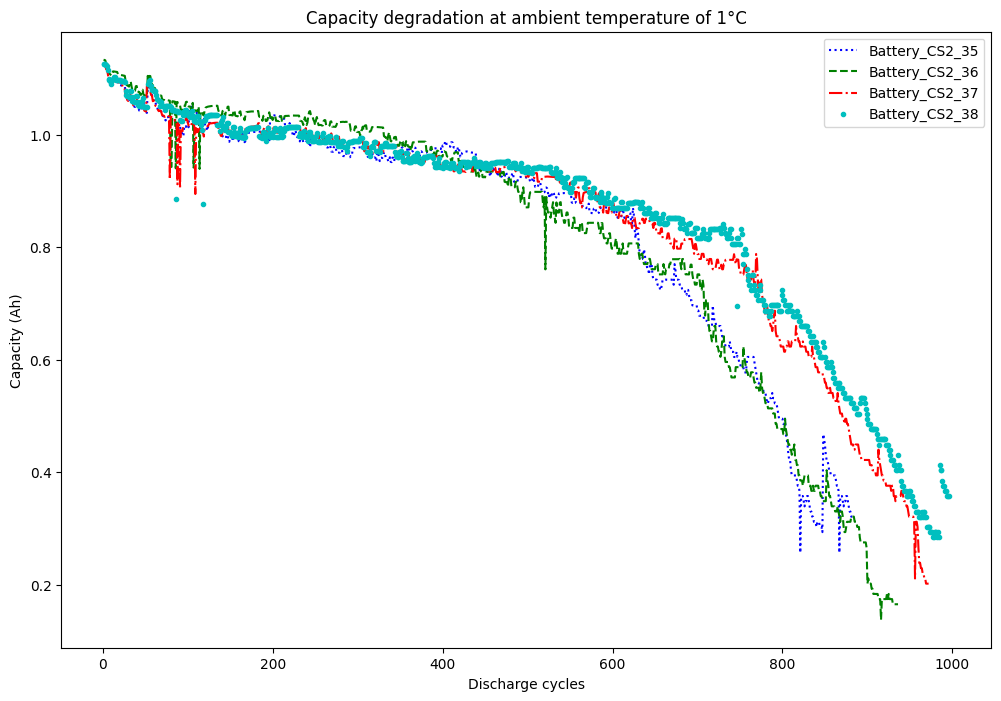

In [28]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [29]:
all_battery_data = pd.concat(Battery.values(), ignore_index=True)
variables = all_battery_data[['cycle', 'capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']].values
variables_filename = 'preprocess/data/data.pkl'
with open(variables_filename, 'wb') as file:
    pickle.dump(variables, file)
# Step 2: Extract and Save the Target Variable
target_variable = all_battery_data['capacity'].values
target_variable_filename = 'preprocess/data/var.pkl'
with open(target_variable_filename, 'wb') as file:
    pickle.dump(target_variable, file)

In [30]:
from torch.utils.data import DataLoader, TensorDataset, random_split
def get_dataloader(battery_data, batch_size=32):
    X = battery_data[['cycle', 'capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']].values
    y = battery_data['capacity'].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)

    train_size = int(0.7 * len(dataset))
    valid_size = int(0.15 * len(dataset))
    test_size = len(dataset) - (train_size + valid_size)
    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

for name in Battery_list:
    train_loader, valid_loader, test_loader = get_dataloader(Battery[name])



In [31]:
import torch.nn.functional as F

def Conv1d_with_init(in_channels, out_channels, kernel_size, device):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size).to(device)
    nn.init.kaiming_normal_(layer.weight)
    
    return layer

class TimeEmbedding(nn.Module):
    def __init__(self, tp, d_model, device):
        super().__init__()
        self.device = device
        self.register_buffer('time_embedding', self._build_embedding(tp + 1, d_model), persistent=False)
    
    def forward(self, m):
        return self.time_embedding[m]
    
    def _build_embedding(self, t, d_model):
        pe = torch.zeros(t, d_model).to(self.device)
        position = torch.arange(t).unsqueeze(1).to(self.device)
        div_term = (1 / torch.pow(10000.0, torch.arange(0, d_model, 2) / d_model)).to(self.device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, device):
        super().__init__()
        self.device = device
        self.register_buffer('diffusion_embedding', self._build_embedding(num_steps, embedding_dim / 2), persistent=False)
        self.projection1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim).to(device)
        
    def forward(self, diffusion_step):
        x = self.diffusion_embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        
        return x
    
    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).to(self.device)
        frequencies = (10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)).to(self.device)
        table = steps * frequencies
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        
        return table

class ResNet(nn.Module):
    def __init__(self, config, device):
            super().__init__()
            var = pickle.load(open('preprocess/data/data.pkl', 'rb'))
            target_var= pickle.load(open('preprocess/data/var.pkl', 'rb'))
            lv = len(var)
            self.size_x = config['size']
            self.size_y = 10 * len(target_var)
            self.channels = config['channels']
            self.emb_f = nn.Embedding(lv + 1, self.channels).to(device)
            self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], device)
            self.emb_v = nn.Linear(1, self.channels).to(device)
            self.dec1 = Conv1d_with_init(self.channels, self.channels, 1, device)
            self.dec2 = Conv1d_with_init(self.channels, 1, 1, device)
            self.diffusion_embedding = DiffusionEmbedding(config['num_steps'], config['diffusion_embedding_dim'], device)
            self.diffusion_projection = nn.Linear(config['diffusion_embedding_dim'], self.channels).to(device)
            self.residual_layers = nn.ModuleList([
                Triplet_cor(config, lv, device)
                for _ in range(config['layers'])])
            
    def forward(self, samples_x, samples_y, info, diffusion_step):
        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)
        diffusion_emb = diffusion_emb.unsqueeze(1).expand(diffusion_emb.shape[0], self.size_x, diffusion_emb.shape[1])
        triplets_x = (self.emb_f(samples_x[:, 0].to(torch.int64))
                    + self.emb_t(samples_x[:, 1].to(torch.int64))
                    + self.emb_v(samples_x[:, 2].unsqueeze(-1))
                    + diffusion_emb) * samples_x[:, 3].unsqueeze(-1)
        triplets_y = (self.emb_f(samples_y[:, 0].to(torch.int64))
                    + self.emb_t(samples_y[:, 1].to(torch.int64))
                    + self.emb_v(samples_y[:, 2].unsqueeze(-1))
                    ) * samples_y[:, 3].unsqueeze(-1)
        diffussion_emb_y = diffusion_emb[:, : self.size_y] * samples_y[:, 3].unsqueeze(-1)
        skip = []
        for layer in self.residual_layers:
            triplets_y = triplets_y + diffussion_emb_y
            triplets_y, skip_connection = layer(triplets_x, triplets_y)
            skip.append(skip_connection)
            
        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)
        
        return output.squeeze()

class Triplet_cor(nn.Module):
    def __init__(self, config, lv, device):
        super().__init__()
        self.channels = config['channels']
        self.attn = torch.nn.Transformer(d_model=self.channels, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation='gelu', batch_first=True, device=device)
        self.expand = Conv1d_with_init(self.channels, 2 * self.channels, 1, device)
    
    def forward(self, triplets_x, triplets_y):
        output = self.attn(triplets_x, triplets_y)
        output = self.expand(output.transpose(1, 2)).transpose(1, 2)
        residual, skip = torch.chunk(output, 2, dim=-1)
        
        return residual, skip

In [32]:
class TDSTF(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.config_diff = config['diffusion']
        var = pickle.load(open('preprocess/data/data.pkl', 'rb'))
        self.lv = len(var)
        self.res_model = ResNet(self.config_diff, self.device)
        # parameters for diffusion model
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch['samples_x'].to(self.device).float()
        samples_y = batch['samples_y'].to(self.device).float()
        info = batch['info'].to(self.device)
        
        return samples_x, samples_y, info

    def forward(self, batch, size_x, size_y):
        samples_x, samples_y, info = self.process(batch)
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t]
        noise = torch.randn((len(samples_x), size_y)).to(samples_y.device)
        mask_x = samples_x[:, 3]
        mask_y = samples_y[:, 3]
        samples_x[:, 0] = torch.where(mask_x == 1, samples_x[:, 0], self.lv)
        samples_x[:, 1] = torch.where(mask_x == 1, samples_x[:, 1], -1)
        samples_y[:, 0] = torch.where(mask_y == 1, samples_y[:, 0], self.lv)
        samples_y[:, 1] = torch.where(mask_y == 1, samples_y[:, 1], -1)
        samples_y[:, 2] = ((current_alpha ** 0.5) * samples_y[:, 2] + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y
        predicted = self.res_model(samples_x, samples_y, info, t)
        residual = torch.where(mask_y == 1, noise - predicted, 0)
        loss = (residual ** 2).sum() / info[:, 2].sum()

        return loss

    def forecast(self, samples_x, samples_y, info, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y[:, 2] = torch.randn_like(samples_y[:, 2]) * samples_y[:, 3]
            for t in range(self.num_steps - 1, -1, -1):
                mask_x = samples_x[:, 3]
                mask_y = samples_y[:, 3]
                samples_x[:, 0] = torch.where(mask_x == 1, samples_x[:, 0], self.lv)
                samples_x[:, 1] = torch.where(mask_x == 1, samples_x[:, 1], -1)
                samples_y[:, 0] = torch.where(mask_y == 1, samples_y[:, 0], self.lv)
                samples_y[:, 1] = torch.where(mask_y == 1, samples_y[:, 1], -1)
                predicted = self.res_model(samples_x, samples_y, info, torch.tensor([t]).to(self.device))
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                samples_y[:, 2] = coeff1 * (samples_y[:, 2] - coeff2 * predicted) * samples_y[:, 3]
                if t > 0:
                    noise = torch.randn_like(samples_y[:, 2]) * samples_y[:, 3]
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y[:, 2] += sigma * noise

            generation[i] = samples_y[:, 2].detach()
            
        return generation.permute(1, 2, 0)

    def evaluate(self, batch, n_samples):
        samples_x, samples_y, info = self.process(batch)
        with torch.no_grad():
            generation = self.forecast(samples_x, samples_y, info, n_samples)
            
        return generation, samples_y, samples_x

In [33]:
import numpy as np
import torch
from torch.optim import Adam
from tqdm import tqdm
import pickle

def train(
    model,
    config,
    train_loader,
    valid_loader=None,
    valid_epoch_interval=10,
    foldername='',
):
    optimizer = Adam(model.parameters(), lr=config['train']['lr'], weight_decay=5e-8)
    if foldername != '':
        output_path = foldername + '/model.pth'
    m = []
    for i in range(int(config['train']['epochs'] / 10)):
        m.append(i * 10)
        
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=m[1:], gamma=0.8)
    # earlystopping count
    ct = 0
    _, target_var = pickle.load(open('preprocess/data/var.pkl', 'rb'))
    size_y = 10 * len(target_var)
    best_valid_loss = np.inf
    for epoch_no in range(config['train']['epochs']):
        avg_loss = 0
        model.train()
        with tqdm(train_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, train_batch in enumerate(it, start=1):
                optimizer.zero_grad()
                loss = model(train_batch, config['diffusion']['size'], size_y)
                loss.backward()
                avg_loss += loss.item()
                optimizer.step()
                it.set_postfix(
                    ordered_dict={
                        'avg_epoch_loss': avg_loss / batch_no,
                        'epoch': epoch_no,
                        'lr': optimizer.param_groups[0]['lr']
                    },
                    refresh=False,
                )
                
            lr_scheduler.step()
        if valid_loader is not None and (epoch_no + 1) % valid_epoch_interval == 0 and epoch_no > 135:
            model.eval()
            CRPS_valid, _ = evaluate(0, model, valid_loader, nsample=5, foldername=foldername)
            print('{} (best)'.format(round(best_valid_loss, 4)))
            print('{} (current)'.format(round(CRPS_valid, 4)))
            if best_valid_loss > CRPS_valid:
                ct = 0
                best_valid_loss = CRPS_valid
                torch.save(model.state_dict(), output_path)
                print('model updated')
            else:
                ct += 1
                print('count: {}'.format(ct))
            # earlystopping
            if ct > 2:
                model.load_state_dict(torch.load(output_path))
                print('stop')
                break

def calc_metrics(is_test, all_generation, all_samples_y):
    MSE = None
    target = all_samples_y[:, 2]
    if is_test == 1:
        quantiles = np.arange(0.05, 1.0, 0.05)
        # calculate MSE
        gt = all_samples_y[:, 2]
        mask = all_samples_y[:, 3]
        prediction = all_generation.median(dim=2)
        MSE = ((prediction.values - gt) * mask) ** 2
        MSE = MSE.sum() / mask.sum()
    else:
        quantiles = np.arange(0.25, 1.0, 0.25)
    denom = torch.sum(torch.abs(target))
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(all_generation)):
            q_pred.append(torch.quantile(all_generation[j], quantiles[i], dim = -1))
        q_pred = torch.cat(q_pred, 0).reshape(-1)
        target = target.reshape(-1)
        q_loss = 2 * torch.sum(torch.abs((q_pred - target) * all_samples_y[:, 3].reshape(-1) * ((target <= q_pred) * 1.0 - quantiles[i])))
        CRPS += q_loss / denom
    
    return CRPS.item() / len(quantiles), MSE

def evaluate(is_test, model, data_loader, nsample=100, foldername=""):
    with torch.no_grad():
        model.eval()
        all_samples_x = []
        all_samples_y = []
        all_generation = []
        with tqdm(data_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                # ground truth values will be replaced with pure noise before generation
                output = model.evaluate(batch, nsample)
                generation, samples_y, samples_x = output
                all_generation.append(generation)
                all_samples_x.append(samples_x)
                all_samples_y.append(samples_y)
            
            all_generation = torch.cat(all_generation)
            all_samples_x = torch.cat(all_samples_x)
            all_samples_y = torch.cat(all_samples_y)
            CRPS, MSE = calc_metrics(is_test, all_generation, all_samples_y)
            if is_test == 1:
                pickle.dump([all_generation, all_samples_y, all_samples_x], open(foldername + "/generated_outputs" + str(nsample) + ".pkl", "wb"))
                pickle.dump([CRPS, MSE], open(foldername + "/result_nsample" + str(nsample) + ".pkl", "wb"))
            return CRPS, MSE

In [34]:
import argparse
import torch
import datetime
import json
import yaml
import os

parser = argparse.ArgumentParser(description='')
parser.add_argument('--device', default='cuda:0')
parser.add_argument('--modelfolder', type=str, default='')
parser.add_argument('--nsample', type=int, default=100)
args, unknown = parser.parse_known_args()
print(args)
config = yaml.safe_load(open('config/base.yaml', 'r'))
print(json.dumps(config, indent=4))
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
foldername = './save/attention_' + current_time + '/'
print('model folder:', foldername)
os.makedirs(foldername, exist_ok=True)
for name in Battery_list:
    train_loader, valid_loader, test_loader = get_dataloader(Battery[name])
    size = config['diffusion']['size']

    model = TDSTF(config, args.device).to(args.device)

    if args.modelfolder == '':
        train(
            model,
            config,
            train_loader,
            valid_loader=valid_loader,
            foldername=foldername,
        )
    else:
        model.load_state_dict(torch.load('./save/' + args.modelfolder + '/model.pth'))

    print('test')
    NACRPS, MSE = evaluate(1, model, test_loader, nsample=args.nsample, foldername=foldername)
    print('NACRPS: {}'.format(NACRPS))
    print('MSE: {}'.format(MSE))

Namespace(device='cuda:0', modelfolder='', nsample=100)
{
    "train": {
        "epochs": 200,
        "batch_size": 32,
        "lr": 0.001
    },
    "diffusion": {
        "size": 60,
        "layers": 3,
        "channels": 128,
        "nheads": 8,
        "time_points": 40,
        "diffusion_embedding_dim": 128,
        "time_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50
    }
}
model folder: ./save/attention_20240527_162835/


AssertionError: Torch not compiled with CUDA enabled

In [42]:
with open('preprocess/data/var.pkl', 'rb') as file:
    data = pickle.load(file)
    var, target_var, *rest = data

print(len(data))

3786
